In [9]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import t
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

%matplotlib inline

/home/pipe/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
data=pd.read_csv("https://serv.cusp.nyu.edu/~lw1474//ADS_Data/session06/data_hw_3_4.csv")
data.head()

,Y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15
0,3.035437,-18.227424,30.521149,-37.494755,31.108940,-8.917930,13.177162,10.153335,17.521327,14.695400,7.222120,3.142381,13.754352,0.115685,6.263643,8.957240
1,1.479243,31.210052,8.273238,17.545475,8.013616,-3.163515,12.632948,10.384905,7.278064,11.506060,21.150410,14.558149,15.393978,13.701066,14.993476,17.993337
2,-1.193325,-2.427634,1.698858,-1.980364,-9.902694,9.215057,9.984092,7.627307,7.701929,15.254064,15.665984,6.676761,14.504275,19.329674,11.312780,13.360359
3,0.634462,-10.778091,-4.718246,-4.861350,13.543559,-10.575067,25.562832,2.064966,12.297941,7.063591,14.787318,4.751835,16.473578,15.697654,3.765299,8.776716
4,-0.125792,5.547746,-10.935812,-1.397010,1.977636,-17.475947,13.159905,18.881544,4.986746,12.079755,13.762270,5.192296,11.656484,13.370774,16.536450,7.264736


In [5]:
n = 15
formula = 'Y ~ x1'
for i in data.columns[2:]:
    formula = formula +'+'+  i 

model = smf.ols(formula = formula + '-1', data = data).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     7.682
Date:                Sun, 30 Oct 2016   Prob (F-statistic):           3.73e-07
Time:                        19:24:16   Log-Likelihood:                -64.562
No. Observations:                  50   AIC:                             159.1
Df Residuals:                      35   BIC:                             187.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             3.3026      1.692      1.951      0.0

## Overfitting problem by 1000 times cross-validation.  Report average OS and IS R-squared.  (10 pts)

In [10]:
R_IS=[]
R_OS=[]

nCross=1000
x = np.array(data.drop('Y',axis=1).copy())
y = np.array(data.Y.copy())


for i in range(nCross):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)    
    res=LinearRegression(fit_intercept=False)
    res.fit(X_train,y_train)
    R_IS.append(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())                                                                     
    R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
print("IS R-squared for {} times is {}".format(nCross,np.mean(R_IS)))
print("OS R-squared for {} times is {}".format(nCross,np.mean(R_OS)))

IS R-squared for 1000 times is 0.809085953198
OS R-squared for 1000 times is 0.259466412687


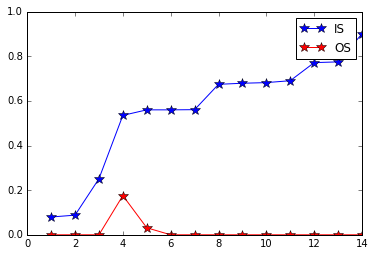

In [11]:
def AdjR2(flag,data):
    '''
    Evalute the model with adjusted R-squared,
    with flag indicating the feature selection
    1--feature included
    0--feature excluded
    '''
    sampleSplit = len(data.index)/2
    formstr='Y~-1'
    for i in range(len(flag)):
        if flag[i]==1:
            formstr += '+x%d'%(i+1) # Construct the regression formula based on flag
    train = data[:sampleSplit]
    valid = data[sampleSplit:]
    lm = smf.ols(formula = formstr, data = train).fit()
    lmy = lm.predict(valid)
    y_err = lmy-valid.Y
    y_norm = valid.Y-np.mean(valid.Y)
    # Adjusted R^2
    R2 = 1 - y_err.dot(y_err) / y_norm.dot(y_norm) * (n-1) / (n-sum(flag)-1)
    return R2, lm

n = 15
adjR2 = []
regR2 = []

for i in range(1, n):
    a,b = AdjR2([1]*i + [0]*(n-i),data)
    regR2.append(b.rsquared)
    if a>0:
        adjR2.append(a)
    else:
        adjR2.append(0)
        
plt.plot(range(1, n), regR2, 'b-*', markersize = 10,label="IS")
# Out of sample R2 (adjusted)
plt.plot(range(1, n), adjR2, 'r-*', markersize = 10,label="OS")
plt.legend()
plt.show()

The best features appear to be **x4** and **x5**

## Function for feature selection

In [12]:
def FindBestI():
    flag = np.zeros(n)    # initially exclude all regressors: 1-include, 0-exclude
    r2max = 0             # for storing and compare with best R^2
    while True:
        flag_mat = np.maximum(np.eye(n),flag)
        # see if R2 increases if we add one more feature
        r2 = np.apply_along_axis(AdjR2,1,flag_mat,data)[:,0]  # 1: row-wise operation, then select R2 only
        temp = r2.max()
        if temp > r2max:
            r2max = temp
            flag = flag_mat[r2.argmax()]  # select this feature if it improves our R2
        else:
            break                         # if there's nothing to add, break the loop
    return flag

flag = FindBestI()             # store the best choice of feature selection
r2_best,lm_best = AdjR2(flag,data)  # then run the regression based on such selection
col = data.columns[1:]
ix = [col[i] for i in range(n) if flag[i]==1]

b = pd.DataFrame({'Pvalues':AdjR2([1]*n,data)[1].pvalues, 'Keeper':col})
c = 'forestgreen'
def highlight_pval(val):
    color = c if val in ix else 'white'
    return 'background-color: %s'%color

b.style.applymap(highlight_pval, subset=['Keeper']).\
    bar(subset = ['Pvalues'], color=c)